In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/home/kaptue/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


### Read data

In [2]:
train_data_path = "/home/kaptue/Bureau/BNPP_Cardif/tweet_sentiment/tweet_data/train.csv"
test_data_path = "/home/kaptue/Bureau/BNPP_Cardif/tweet_sentiment/tweet_data/test.csv"

In [3]:
train_df = pd.read_csv(filepath_or_buffer=train_data_path)

In [4]:
train_df.head()

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive


In [5]:
n,p = train_df.shape
n, p

(27486, 4)

In [6]:
train_df.describe()

,textID,text,selected_text,sentiment
count,27486,27485,27485,27486
unique,27486,27485,22579,3
top,5bac5df5db,i thought it was already winter. turns out win...,good,neutral
freq,1,1,195,11118


In [7]:
train_df.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [8]:
# fill nan values with empty chars
train_df = train_df.fillna("")

### Exploration et nettoyage de données textuelles

* **Nettoyage** : Suppression des caractères mal codés et de ponctuation, transformation des majuscules en minuscules, en remarquant que ces transformations ne seraient pas pertinentes pour un objectif de détection de pourriels.
* **StopWord** : Suppression des mots inutiles ou mots de liaison, articles qui n'ont a priori pas de pouvoir discriminant.
* **Stemming** (ou Racinisation): Les mots sont réduits à leur seule racine afin de réduire la taille du dictionnaire.

In [9]:
import unicodedata 
import time
import pandas as pd
import numpy as np
import random
import nltk
import re 
import collections
import itertools
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")

import sklearn.model_selection as sms

#### some nice plots

In [10]:
train_df.sentiment.value_counts()

neutral     11118
positive     8582
negative     7786
Name: sentiment, dtype: int64

In [11]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure

output_notebook()

Loading BokehJS ...

In [12]:
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral3

sentiments = list(train_df.sentiment.unique())
counts = list(train_df.sentiment.value_counts())

source = ColumnDataSource(data=dict(sentiments=sentiments, counts=counts, color=Spectral3))

p = figure(x_range=sentiments, plot_height=250, y_range=(0, 15000), title="Sentiment Counts")
p.vbar(x='sentiments', top='counts', width=0.7, color='color', legend_field="sentiments", source=source)

p.xgrid.grid_line_color = None
p.legend.orientation = "horizontal"
p.legend.location = "top_center"

show(p)

In [13]:
%matplotlib inline
from IPython.display import SVG, HTML
html_pygal = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/pygal-tooltips.js"></script>
    <!-- ... -->
  </head>
  <body>
    <figure>
      {pygal_render}
    </figure>
  </body>
</html>
"""

In [14]:
import pygal

sentiments = list(train_df.sentiment.unique())
counts = list(train_df.sentiment.value_counts())

bar_chart = pygal.Bar(height=400)

bar_chart.title = 'Sentiment counts (in %)'
bar_chart.add(sentiments[0], (counts[0]*100)/n)
bar_chart.add(sentiments[1], (counts[1]*100)/n)
bar_chart.add(sentiments[2], (counts[2]*100)/n)
HTML(html_pygal.format(pygal_render=bar_chart.render()))

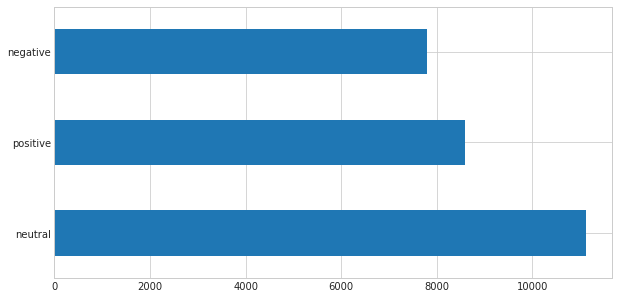

In [15]:
fig=plt.figure(figsize= (10,5))
ax = fig.add_subplot(1,1,1)
train_df.sentiment.value_counts().plot.barh(logx = False)
plt.show()

#### conversion en minuscule

In [16]:
i = int(np.random.choice(range(n), 1)) #11160
txt = train_df.text[i]
txt

' Sorry to hear about the laptop troubles. Hope you can get them fixed and the lappy back to norm.'

In [17]:
txt = txt.lower()
print(txt)

 sorry to hear about the laptop troubles. hope you can get them fixed and the lappy back to norm.


#### supprimer les caractères spéciaux

In [18]:
txt = txt.replace(u'\u2026','.')    # les trois points 
txt = txt.replace(u'\u00a0',' ')    # \xa0 souvent présent dans les chaînes
txt = txt.replace(u'\u005F',' ')    # underscore
txt

' sorry to hear about the laptop troubles. hope you can get them fixed and the lappy back to norm.'

#### retirer la ponctuation 

In [19]:
import string

In [20]:
txt = "".join([c for c in txt if c not in string.punctuation])
txt

' sorry to hear about the laptop troubles hope you can get them fixed and the lappy back to norm'

#### supprimer les caractères qui ne sont pas des  lettres minuscules (double check)

In [21]:
txt = re.sub('[^a-z_]', ' ', txt)
print(txt)

 sorry to hear about the laptop troubles hope you can get them fixed and the lappy back to norm


#### tokenization et suppressions des stopwords ainsi que les mots de taille inférieure à 2

In [22]:
## listes de mots à supprimer dans le tweet
## Depuis NLTK
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english') 
stopwords[:15]

[nltk_data] Downloading package stopwords to /home/kaptue/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours']

In [23]:
#suppression de la ponctuation des stopwords
"""
updated_stopwords = []
for word in stopwords:
    word = "".join([c for c in word if c not in string.punctuation])
    updated_stopwords.append(word)
print(updated_stopwords[:15])

stopwords = list(np.unique(updated_stopwords))
"""

'\nupdated_stopwords = []\nfor word in stopwords:\n    word = "".join([c for c in word if c not in string.punctuation])\n    updated_stopwords.append(word)\nupdated_stopwords[:15]\n'

In [43]:
stopwords.append('im')

# générer des tokens
tokens = [w for w in txt.split() if (len(w)>2) and (w not in stopwords)]
removed_words = [w for w in txt.split() if (len(w)<2) or (w in stopwords)]

print(tokens)
print(removed_words)

['sorry', 'hear', 'laptop', 'troubles', 'hope', 'get', 'fixed', 'lappy', 'back', 'norm']
['to', 'about', 'the', 'you', 'can', 'them', 'and', 'the', 'to']


#### Lemmatization

In [26]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/kaptue/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [27]:
lemmatizer = WordNetLemmatizer()
lem_txt = [lemmatizer.lemmatize(i) for i in tokens]
print(lem_txt)

['sorry', 'hear', 'laptop', 'trouble', 'hope', 'get', 'fixed', 'lappy', 'back', 'norm']


#### Stemming

In [28]:
from nltk.stem.porter import PorterStemmer

In [29]:
stemmer = PorterStemmer()
stem_txt = [stemmer.stem(i) for i in tokens]
print(stem_txt)

['sorri', 'hear', 'laptop', 'troubl', 'hope', 'get', 'fix', 'lappi', 'back', 'norm']


#### cleaning function

In [44]:
def hoover(txt):
    ### lower case
    txt = txt.lower()
    ### remove some special caracters
    txt = txt.replace(u'\u2026','.')    
    txt = txt.replace(u'\u00a0',' ')   
    txt = txt.replace(u'\u005F',' ')
    ### remove punctuation
    txt = "".join([c for c in txt if c not in string.punctuation])
    ### remove non alphanumeric char
    txt = re.sub('[^a-z_]', ' ', txt)
    ### remove english stopwords
    tokens = [w for w in txt.split() if (w not in stopwords)] # (len(w)>2) and (not necessary)
    ### english lemmatization
    tokens_lem = [lemmatizer.lemmatize(i) for i in tokens]
    return ' '.join(tokens), " ".join(tokens_lem)

In [45]:
import time

In [46]:
def clean_df(data, column_names=["text", "selected_text"]):
    clean_list = []
    clean_lem_list = []
    time_start = time.time()
    for column_name in column_names:
        column_values = data[column_name].values
        A = np.array(list(map(hoover, column_values)))
        array_clean = A[:,0]
        array_clean_lem = A[:,1]
        clean_list.append(array_clean)
        clean_lem_list.append(array_clean_lem)
    time_end = time.time()
    print("Cleaning time: %d secondes"%(time_end-time_start))
    # create new columns
    new_colnames = [col + "_clean" for col in column_names]
    array_clean = np.array(clean_list).T
    data = data.join(pd.DataFrame(array_clean, columns = new_colnames))
    
    new_colnames = [col + "_clean_lem" for col in column_names]
    array_clean_lem = np.array(clean_lem_list).T
    data = data.join(pd.DataFrame(array_clean_lem, columns = new_colnames))
    return data

### Nettoyage du dataframe 

In [47]:
warnings.filterwarnings("ignore")
train_df_clean = clean_df(train_df)

Cleaning time: 2 secondes


In [48]:
train_df_clean.head()

,textID,text,selected_text,sentiment,text_clean,selected_text_clean,text_clean_lem,selected_text_clean_lem
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,neutral,spent entire morning meeting w vendor boss hap...,boss happy w lots fun,spent entire morning meeting w vendor bos happ...,bos happy w lot fun
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,positive,oh good idea putting ice cream,good,oh good idea putting ice cream,good
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,neutral,says good say bad afternoon httpplurkcompwxpdj,says good say bad afternoon,say good say bad afternoon httpplurkcompwxpdj,say good say bad afternoon
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,negative,dont think vote anymore tried,dont think vote anymore,dont think vote anymore tried,dont think vote anymore
4,bf7473b12d,haha better drunken tweeting you mean?,better,positive,haha better drunken tweeting mean,better,haha better drunken tweeting mean,better


#### Taille du dictionnaire de mots avant et après le nettoyage

In [49]:
concatenate_text = " ".join(train_df["text"].values)
list_of_word = concatenate_text.split(" ")
N = len(set(list_of_word))
print(N)

52274


In [50]:
concatenate_text = " ".join(train_df_clean["text_clean"].values)
list_of_word = concatenate_text.split(" ")
N = len(set(list_of_word))
print(N)

28272


In [51]:
concatenate_text = " ".join(train_df_clean["text_clean_lem"].values)
list_of_word = concatenate_text.split(" ")
N = len(set(list_of_word))
print(N)

26308


### Wordcloud

In [52]:
from wordcloud import WordCloud

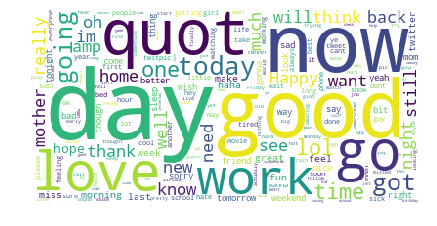

In [55]:
all_text = " ".join(train_df["text"].values)
wordcloud_word = WordCloud(background_color="white", collocations=False).generate_from_text(all_text)

plt.figure(figsize=(7,7))
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

#### Après nettoyage

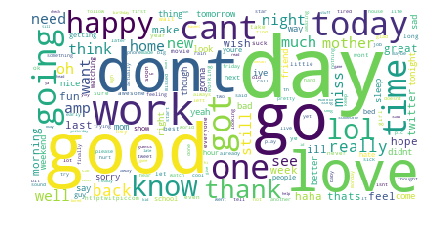

In [56]:
all_text_clean_lem = " ".join(train_df_clean["text_clean_lem"].values)
wordcloud_word = WordCloud(background_color="white", collocations=False).generate_from_text(all_text_clean_lem)

plt.figure(figsize=(7,7))
plt.imshow(wordcloud_word,cmap=plt.cm.Paired)
plt.axis("off")
plt.show()

In [58]:
train_df_clean.to_csv("../tweet_data/train_clean_stem.csv", index=False)